## Importing Libraries

In [2]:
import sys
import numpy as np
import pandas as pd
from skimage.io import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.preprocessing import image

from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

2022-04-16 18:05:19.443630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aron/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-16 18:05:19.443666: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Making Folders and Setting Directories

In [3]:
DATA_PATH= os.path.join('datasets/')
TRAIN_PATH=os.path.join(DATA_PATH,'train')
VAL_PATH=os.path.join(DATA_PATH,'validate')
SAV_PATH=os.path.join(DATA_PATH, 'resized-data')

In [4]:

# os.makedirs(SAV_PATH)

In [5]:
print (os.listdir(TRAIN_PATH))

['bat', 'hedgehog', 'antelope', 'rat', 'rhinoceros', 'okapi', 'octopus', 'badger', 'deer', 'wolf', 'reindeer', 'dolphin', 'dog', 'hare', 'hippopotamus', 'wombat', 'mouse', 'whale']


In [6]:
print (os.listdir(VAL_PATH))

['lobster', 'raccoon', 'possum', 'turtle', 'crab', 'tiger', 'coyote', 'gorilla', 'grasshopper', 'hamster', 'porcupine', 'moth', 'turkey', 'mosquito', 'crow']


## Loading the training and validation datasets

In [7]:
for directory in os.listdir(TRAIN_PATH):
    file= os.listdir(os.path.join(TRAIN_PATH,directory))[0]
    img=cv2.imread(os.path.join(TRAIN_PATH,directory,file))
    print(f'File: {file}, Size: {img.shape} Feature: {img.flatten()}')

File: 0de51464d4.jpg, Size: (168, 300, 3) Feature: [12 19 16 ...  3  3  3]
File: 6cb2744f5a.jpg, Size: (1228, 2880, 3) Feature: [183 180 189 ...  81 107 153]
File: 9acc1d8400.jpg, Size: (168, 300, 3) Feature: [146 137 133 ...  90  82  89]
File: 20a23cf2c7.jpg, Size: (137, 368, 3) Feature: [255 255 255 ... 255 255 255]
File: 7bfbd4056d.jpg, Size: (450, 360, 3) Feature: [ 67  83  66 ... 141 190 228]
File: 0a7783e87e.jpg, Size: (168, 299, 3) Feature: [  5  50  23 ... 240 251 255]
File: 61df1f1dfe.jpg, Size: (1400, 1400, 3) Feature: [21 14 17 ...  9  7  7]
File: 047c50963a.jpg, Size: (1129, 1417, 3) Feature: [254 254 254 ... 254 254 254]
File: 47e15465e6.jpg, Size: (1543, 2000, 3) Feature: [ 65 122  77 ...  26  48  53]
File: 9aaeb59193.jpg, Size: (187, 270, 3) Feature: [190 162 162 ... 243 246 251]
File: 7dd34833ce.jpg, Size: (675, 1200, 3) Feature: [0 0 0 ... 0 0 0]
File: 7cc3758d67.jpg, Size: (174, 290, 3) Feature: [206 157  17 ... 172 124   0]
File: 9a8262798f.jpg, Size: (194, 259, 3) F

In [8]:
def loadimgs(path, n=0):
    '''path=> Path of the train or test directory'''
    X=[]
    y=[]
    cat_dict={}
    curr_y = n
    # We load every animal separately so we can isolate them later
    for animal in os.listdir(path):
        print("Loading animal:", animal)
        cat_dict[animal]=(curr_y)
        category_images=[]
        animal_image_path=os.path.join(path,animal)
        for filename in os.listdir(animal_image_path):
            image_path=os.path.join(animal_image_path, filename)
            image=cv2.imread(image_path)
            resized=cv2.resize(image, (224,224),interpolation=cv2.INTER_AREA)
            rescaled=1.0/255*resized
            category_images.append(rescaled)
            y.append(curr_y)
        try:
            X.append(np.stack(category_images))
        except ValueError as e:
            print(e)
            print("Error-Category_images:", category_images)
        curr_y+=1
    y=np.vstack(y)
    X=np.stack(X)
    print("Loading Complete")
    return X,y,cat_dict

In [9]:
X,y,c=loadimgs(TRAIN_PATH)

Loading animal: bat
Loading animal: hedgehog
Loading animal: antelope
Loading animal: rat
Loading animal: rhinoceros
Loading animal: okapi
Loading animal: octopus
Loading animal: badger
Loading animal: deer
Loading animal: wolf
Loading animal: reindeer
Loading animal: dolphin
Loading animal: dog
Loading animal: hare
Loading animal: hippopotamus
Loading animal: wombat
Loading animal: mouse
Loading animal: whale
Loading Complete


In [10]:
with open(os.path.join(SAV_PATH,"train.pickle"),"wb") as f:
    pickle.dump((X,c),f)

In [11]:
X.shape
# 46 categories of animal, each containg 60 images and of dimensions 64*64*3

(18, 60, 224, 224, 3)

In [12]:
y.shape

(1080, 1)

In [13]:
c.keys()

dict_keys(['bat', 'hedgehog', 'antelope', 'rat', 'rhinoceros', 'okapi', 'octopus', 'badger', 'deer', 'wolf', 'reindeer', 'dolphin', 'dog', 'hare', 'hippopotamus', 'wombat', 'mouse', 'whale'])

In [14]:
c


{'bat': 0,
 'hedgehog': 1,
 'antelope': 2,
 'rat': 3,
 'rhinoceros': 4,
 'okapi': 5,
 'octopus': 6,
 'badger': 7,
 'deer': 8,
 'wolf': 9,
 'reindeer': 10,
 'dolphin': 11,
 'dog': 12,
 'hare': 13,
 'hippopotamus': 14,
 'wombat': 15,
 'mouse': 16,
 'whale': 17}

In [15]:
Xval, yval,cval=loadimgs(VAL_PATH)

Loading animal: lobster
Loading animal: raccoon
Loading animal: possum
Loading animal: turtle
Loading animal: crab
Loading animal: tiger
Loading animal: coyote
Loading animal: gorilla
Loading animal: grasshopper
Loading animal: hamster
Loading animal: porcupine
Loading animal: moth
Loading animal: turkey
Loading animal: mosquito
Loading animal: crow
Loading Complete


In [16]:
with open(os.path.join(SAV_PATH,"val.pickle"),"wb") as f:
    pickle.dump((Xval,cval),f)

In [17]:
Xval.shape

(15, 60, 224, 224, 3)

In [18]:
yval.shape

(900, 1)

In [19]:
cval.keys()

dict_keys(['lobster', 'raccoon', 'possum', 'turtle', 'crab', 'tiger', 'coyote', 'gorilla', 'grasshopper', 'hamster', 'porcupine', 'moth', 'turkey', 'mosquito', 'crow'])

## Loading the saved pickle data

In [20]:
with open(os.path.join(SAV_PATH, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['bat', 'hedgehog', 'antelope', 'rat', 'rhinoceros', 'okapi', 'octopus', 'badger', 'deer', 'wolf', 'reindeer', 'dolphin', 'dog', 'hare', 'hippopotamus', 'wombat', 'mouse', 'whale']


In [21]:
with open(os.path.join(SAV_PATH, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['lobster', 'raccoon', 'possum', 'turtle', 'crab', 'tiger', 'coyote', 'gorilla', 'grasshopper', 'hamster', 'porcupine', 'moth', 'turkey', 'mosquito', 'crow']


In [22]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape[0], X.shape[1], X.shape[2], X.shape[3]

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,3)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 3)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,3)
    
    return pairs, targets

In [23]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [24]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape[0], X.shape[1], X.shape[2], X.shape[3]
    
    indices = rng.randint(0, n_examples,size=(N,))
    categories = rng.choice(range(n_classes),size=(N,),replace=False)
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))

    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,3)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,3)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [25]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w = X.shape[0], X.shape[1], X.shape[2]
    X = X.reshape(nc, h, w,3)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h,3))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [26]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(224,224,3))
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

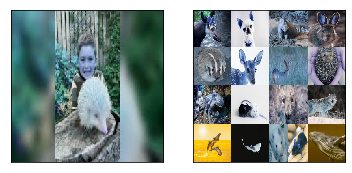

In [27]:
pairs, targets = make_oneshot_task(16,"train")
plot_oneshot_task(pairs)

## Siamese Model

In [28]:
def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [29]:
def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [30]:
import tensorflow as tf
import keras
# import keras.application
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet50
from keras.applications.resnet import decode_predictions
from keras.applications.resnet import preprocess_input
from keras.models import Model,Sequential
from keras.layers import Input,UpSampling2D,Flatten,BatchNormalization,Dense,Dropout,GlobalAveragePooling2D
from keras import optimizers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from PIL import Image

In [31]:
IMAGE_SIZE = [224, 224]

In [32]:
resnet=ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

2022-04-16 18:14:48.704743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aron/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-16 18:14:48.704767: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-16 18:14:48.704786: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aron-Nitro-AN515-55): /proc/driver/nvidia/version does not exist
2022-04-16 18:14:48.705755: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 60
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

In [34]:
nb_epochs = 1
NUM_CLASSES = 10

# Fixed for Cats & Dogs color images
CHANNELS = 3

In [35]:
from keras import optimizers
from keras.models import Model,Sequential

In [36]:



model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(6, activation = 'softmax'))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

model.summary()



sgd = tf.keras.optimizers.SGD (lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer =sgd , loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


/home/aron/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [44]:
def get_siamese_model(input_shape):
    BATCH_SIZE_TRAINING = 10
    BATCH_SIZE_VALIDATION = 10
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
#     model = Sequential()
#     model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_shape,
#                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
#     model.add(MaxPooling2D(2,2))
#     model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer=initialize_weights,
#                      bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
#     model.add(MaxPooling2D(2,2))
#     model.add(Conv2D(64, (3,3), activation='relu',kernel_initializer=initialize_weights,
#                      bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
#     model.add(Conv2D(64, (3,3), activation='relu',kernel_initializer=initialize_weights,
#                      bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
#     model.add(MaxPooling2D(2,2))
#     model.add(Flatten())
#     model.add(Dense(256, activation='sigmoid',kernel_regularizer=l2(1e-3),
#                    kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
#     model.add(Dense(256, activation='sigmoid',kernel_regularizer=l2(1e-3),
#                    kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    # 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is

    model = Sequential()
    model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

    # 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
    model.add(Dense(10, activation = 'softmax'))

    # Say not to train first layer (ResNet) model as it is already trained
    model.layers[0].trainable = False

    model.summary()



    sgd = tf.keras.optimizers.SGD (lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
    model.compile(optimizer =sgd , loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [45]:
model = get_siamese_model((224, 224, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                      

In [46]:
optimizer = Adam(learning_rate = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [53]:
model_path =os.getcwd()+'/weight'
os.makedirs(model_path)

In [48]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [49]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 10
n_iter = 20000 # No. of training iterations
N_way = 10 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 200 iterations: 3.7232706546783447 mins
Train Loss: 0.6847477555274963
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 12.4% 10 way one-shot learning accuracy 

Current best: 12.4, previous best: -1

 ------------- 

Time for 400 iterations: 12.265324771404266 mins
Train Loss: 0.6897138357162476
Evaluating model on 250 random 10 way one-shot learning tasks ... 

